In [1]:
import os
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

from xgboost import XGBClassifier


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv


**I will read the data and consider the hypotheses that arise from analyzing the data**
# #1 Getting Startedf1_score

In [2]:
df = pd.read_csv('/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')

In [3]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


**I think that if delete the missing data, it will not affect the further learning,  
because it is not a good idea to fill in the data mean. For this reason, we should just delete them.**

In [5]:
df['bmi'] = df['bmi'].fillna(value=df['bmi'].mean())
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                5110 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


**I will now look at the uniqueness of the categorical data**

In [6]:
[
    print(f'{col_name}: {df[col_name].unique()}') 
    for col_name in [
        col for col in df.columns 
        if df[col].dtype == 'object'
    ]
] # Sorry, but I like use list comprehension

gender: ['Male' 'Female' 'Other']
ever_married: ['Yes' 'No']
work_type: ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type: ['Urban' 'Rural']
smoking_status: ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


[None, None, None, None, None]

**It seems to me that the ever_married and residence_type fields are not the main ones here, why do I think so.  
I'm not an expert on this, I'd have to read more, but I don't think a stroke depends on whether a person is married or not.  
I think the same with the type of residence, I think that a person wherever they are is not immune to it.  
To prove or disprove this, I will construct graphs.**

## #1.1 Visualization of married and unmarried people

In [7]:
married = df[df['ever_married'] == 'Yes'].groupby(['stroke'])['ever_married'].count().reset_index()
unmarried = df[df['ever_married'] == 'No'].groupby(['stroke'])['ever_married'].count().reset_index()

**As we can see in the graphs, the possibility of stroke is greater for married people.  
Apparently I was wrong about this field being unnecessary.  
Most likely it does not depend on whether the person was married or not,  
but depends on the age of the person, i.e. his age is this dependence.**

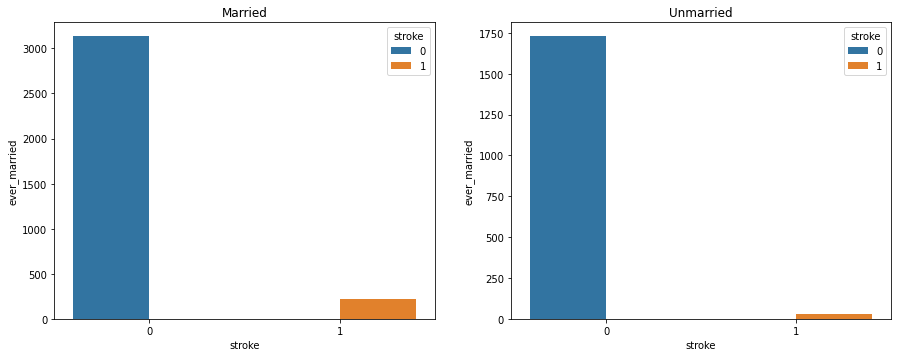

In [8]:
plt.figure(figsize=(15, 12))
plt.subplot(2,2,1)
plt.title('Married')
sns.barplot(x='stroke', y='ever_married', hue='stroke', data=married)
plt.subplot(2,2,2)
plt.title('Unmarried')
sns.barplot(x='stroke', y='ever_married', hue='stroke', data=unmarried)
plt.show()

## #1.2 Urban and rural visualization

In [9]:
urban = df[df['Residence_type'] == 'Urban'].groupby(['stroke'])['Residence_type'].count().reset_index()
rural = df[df['Residence_type'] == 'Rural'].groupby(['stroke'])['Residence_type'].count().reset_index()

**As we can see on the graphs, the data are not very different,  
so I think this field is really not very necessary, so I will  
eliminate it for training in the future.**

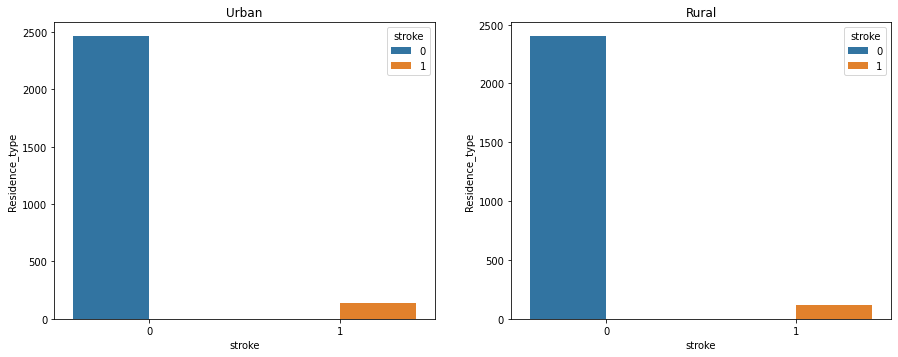

In [10]:
plt.figure(figsize=(15, 12))
plt.subplot(2,2,1)
plt.title('Urban')
sns.barplot(x='stroke', y='Residence_type', hue='stroke', data=urban)
plt.subplot(2,2,2)
plt.title('Rural')
sns.barplot(x='stroke', y='Residence_type', hue='stroke', data=rural)
plt.show()

## #1.3 Visualization of work types 

In [11]:
private = df[df['work_type'] == 'Private'].groupby(['stroke'])['work_type'].count().reset_index()
self_employed = df[df['work_type'] == 'Self-employed'].groupby(['stroke'])['work_type'].count().reset_index()
govt_job = df[df['work_type'] == 'Govt_job'].groupby(['stroke'])['work_type'].count().reset_index()
children = df[df['work_type'] == 'children'].groupby(['stroke'])['work_type'].count().reset_index()
never_worked = df[df['work_type'] == 'Never_worked'].groupby(['stroke'])['work_type'].count().reset_index()

**As we can see from the graphs, you can see that they are almost similar to each other.  
I can note only two types of different graphs from the other graphs. They are children and the unemployed.  
So I don't think you can predict anything good from these charts and this data, because the data is similar, ~25 units different**

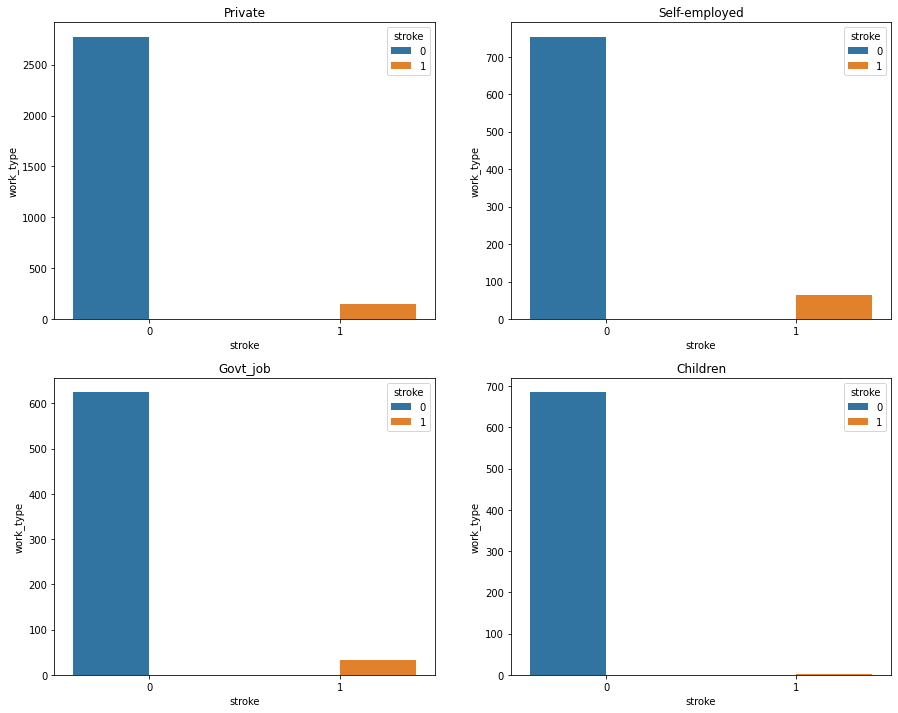

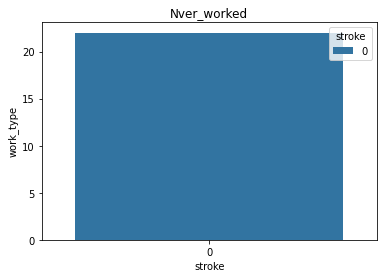

In [12]:
plt.figure(figsize=(15, 12))
plt.subplot(2,2,1)
plt.title('Private')
sns.barplot(x='stroke', y='work_type', hue='stroke', data=private)
plt.subplot(2,2,2)
plt.title('Self-employed')
sns.barplot(x='stroke', y='work_type', hue='stroke', data=self_employed)
plt.subplot(2,2,3)
plt.title('Govt_job')
sns.barplot(x='stroke', y='work_type', hue='stroke', data=govt_job)
plt.subplot(2,2,4)
plt.title('Children')
sns.barplot(x='stroke', y='work_type', hue='stroke', data=children)
plt.show()
plt.title('Nver_worked')
sns.barplot(x='stroke', y='work_type', hue='stroke', data=never_worked)
plt.show()

## #1.4 Visualization by status of smoking

In [13]:
formerly_smoked = df[df['smoking_status'] == 'formerly smoked'].groupby(['stroke'])['smoking_status'].count().reset_index()
never_smoked = df[df['smoking_status'] == 'never smoked'].groupby(['stroke'])['smoking_status'].count().reset_index()
smokes = df[df['smoking_status'] == 'smokes'].groupby(['stroke'])['smoking_status'].count().reset_index()
unknown = df[df['smoking_status'] == 'Unknown'].groupby(['stroke'])['smoking_status'].count().reset_index()

**What can tell from these graphs?  
I think that these graphs again do not reflect very well the possibility of stroke.**

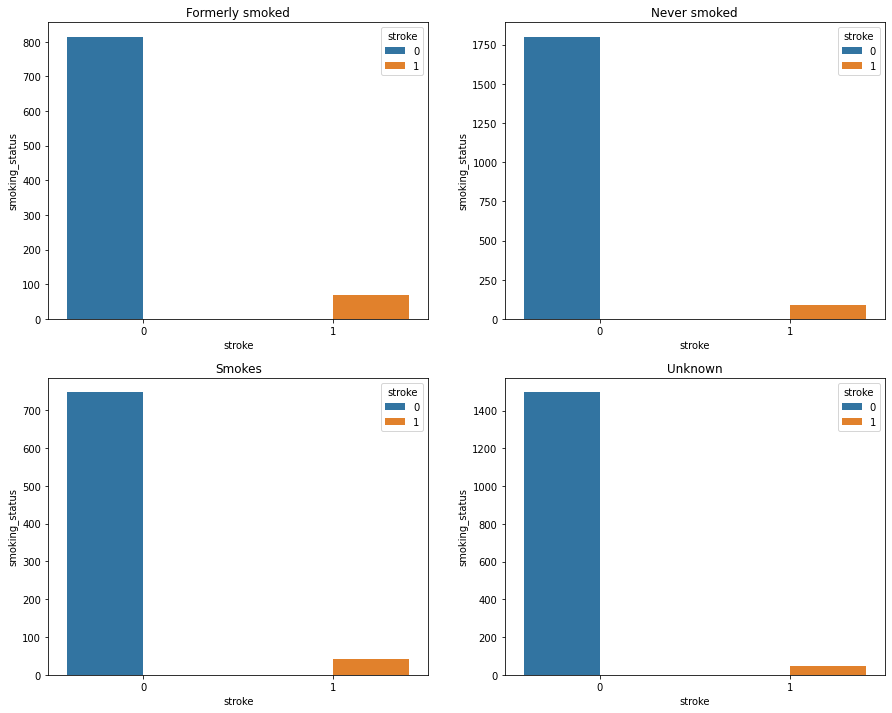

In [14]:
plt.figure(figsize=(15, 12))
plt.subplot(2,2,1)
plt.title('Formerly smoked')
sns.barplot(x='stroke', y='smoking_status', hue='stroke', data=formerly_smoked)
plt.subplot(2,2,2)
plt.title('Never smoked')
sns.barplot(x='stroke', y='smoking_status', hue='stroke', data=never_smoked)
plt.subplot(2,2,3)
plt.title('Smokes')
sns.barplot(x='stroke', y='smoking_status', hue='stroke', data=smokes)
plt.subplot(2,2,4)
plt.title('Unknown')
sns.barplot(x='stroke', y='smoking_status', hue='stroke', data=unknown)
plt.show()

## #1.5 Visualization by gender

In [15]:
male = df[df['gender'] == 'Male'].groupby(['stroke'])['gender'].count().reset_index()
female = df[df['gender'] == 'Female'].groupby(['stroke'])['gender'].count().reset_index()
other = df[df['gender'] == 'Other'].groupby(['stroke'])['gender'].count().reset_index()

**On these graphs we can also see the similarity of these data, it turns out that there is nothing to judge from them.**

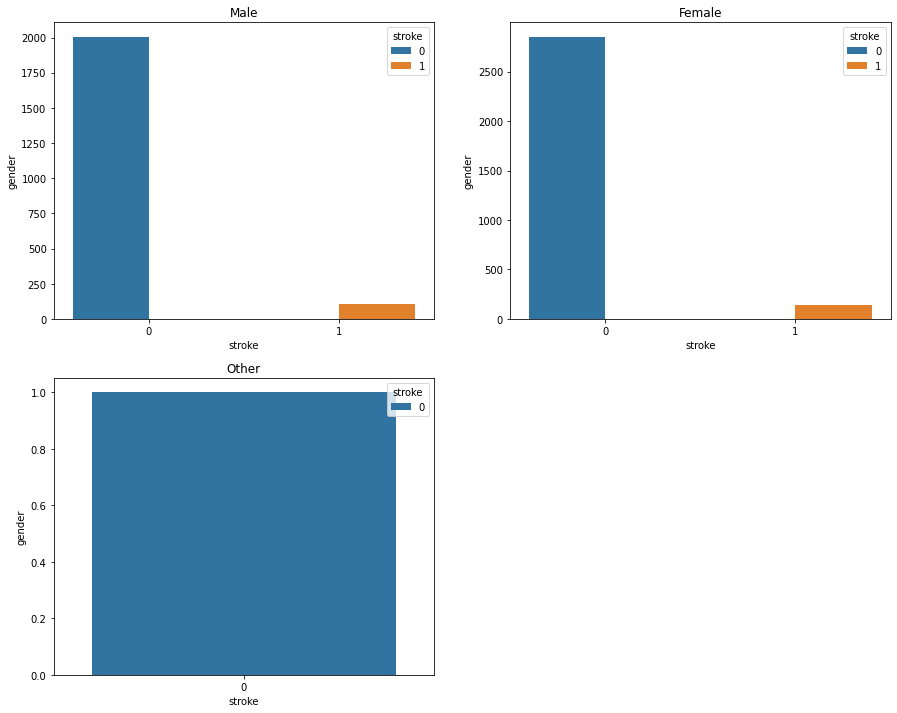

In [16]:
plt.figure(figsize=(15, 12))
plt.subplot(2,2,1)
plt.title('Male')
sns.barplot(x='stroke', y='gender', hue='stroke', data=male)
plt.subplot(2,2,2)
plt.title('Female')
sns.barplot(x='stroke', y='gender', hue='stroke', data=female)
plt.subplot(2,2,3)
plt.title('Other')
sns.barplot(x='stroke', y='gender', hue='stroke', data=other)
plt.show()

## Summary of these charts.
**I dare to assume that there is not much good to assume on these feature, because  
I did not notice a big change, that is, the data is not very different, although they belong to different categories.  
Having redone this job, I don't think should exclude any columns, let's see what happens.**

In [17]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.698018,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.800000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.400000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,32.800000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


**You can see the minimum age of ~0, I do not know if this is good or not.**

# #2 Preprocessing

In [18]:
le = LabelEncoder()
object_col = [col for col in df.columns if df[col].dtype == 'object']
for col in object_col:
    df[col] = le.fit_transform(df[col])

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   int64  
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   int64  
 6   work_type          5110 non-null   int64  
 7   Residence_type     5110 non-null   int64  
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                5110 non-null   float64
 10  smoking_status     5110 non-null   int64  
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(9)
memory usage: 479.2 KB


# #3 Modeling

In [20]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1:]
x_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.33,
                                                    random_state=42)

In [21]:
x_train = x_train.drop(axis=1, columns=['id'])
x_test = X_test.drop(axis=1, columns=['id'])

In [22]:
indexes = ['accuracy', 'f1_score']

## #3.1 LogisticRegression

In [23]:
lr = LogisticRegression()
lr.fit(x_train, y_train)

LogisticRegression()

In [24]:
lr_pred = lr.predict(x_test)
lr_acc = accuracy_score(lr_pred, y_test)
lr_f1 = f1_score(lr_pred, y_test)
lr_frame = pd.DataFrame({
    'LogisticRegression': [lr_acc, lr_f1]
}, index=indexes)

## #3.2 RandomForestClassifier

In [25]:
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)

RandomForestClassifier()

In [26]:
rfc_pred = rfc.predict(x_test)
rfc_acc = accuracy_score(rfc_pred, y_test)
rfc_f1 = f1_score(rfc_pred, y_test)
rfc_frame = pd.DataFrame({
    'RandomForestClassifier': [rfc_acc, rfc_f1]
}, index=indexes)

## #3.3 DecisionTreeClassifier

In [27]:
tree = DecisionTreeClassifier()
tree.fit(x_train, y_train)

DecisionTreeClassifier()

In [28]:
tree_pred = tree.predict(x_test)
tree_acc = accuracy_score(tree_pred, y_test)
tree_f1 = f1_score(tree_pred, y_test)
tree_frame = pd.DataFrame({
    'DecisionTreeClassifier': [tree_acc, tree_f1]
}, index=indexes)

## #3.4 XGBClassifier

In [29]:
xgb = XGBClassifier()
xgb.fit(x_train, y_train)

[08:17:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [30]:
xgb_pred = xgb.predict(x_test)
xgb_acc = accuracy_score(xgb_pred, y_test)
xgb_f1 = f1_score(xgb_pred, y_test)
xgb_frame = pd.DataFrame({
    'XGBClassifier': [xgb_acc, xgb_f1]
}, index=indexes)

In [31]:
pd.concat([lr_frame, rfc_frame, tree_frame, xgb_frame], axis=1)

,LogisticRegression,RandomForestClassifier,DecisionTreeClassifier,XGBClassifier
accuracy,0.943094,0.942501,0.906935,0.936574
f1_score,0.000000,0.020202,0.169312,0.130081


# Saving the result

In [32]:
submission = pd.DataFrame({
    'id': X_test['id'],
    'stroke': xgb_pred
})
submission.to_csv('submission.csv', index=False)
submission

,id,stroke
4688,40041,0
4478,55244,0
3849,70992,0
4355,38207,1
3826,8541,0
...,...,...
319,1686,0
2399,69668,0
1589,49815,0
682,61300,0


# Summary
**The great thing that we can notice is that even without playing with the parameters  
we can get a decent result. On an ordinary logistic regression. Maybe my result is not  
so good, but I think that, we need more information on stroke. Thank you for checking my work.  
I would be happy to have any comments and evaluations.**  
****
**f1_score = 0.0, I think this is because TP or TN is zero**

# Thanks for reading. Don't forget to upvote the work. Good luck kaggling!